<h1><center>Lab3: Music Genre Identification and Emotion Extraction</center></h1>

In [1]:
import os
import numpy as np
import re

#features extraction
import librosa
import librosa.display

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

#dataloading
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from IPython.display import FileLink

#pythorch
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.multiclass import unique_labels

## Python class for model traininig, evaluation and plotting

In [36]:
class ΜyPytorchModel:
    
    def __init__(self, **settings):
        super(ΜyPytorchModel, self).__init__()    
        self.set_device()
    
    def save_settings(self,**settings):
        self.model_type= list(settings.keys())[0]
        self.model_params= self.get_settings([self.model_type],**settings)
        self.train_params= self.get_settings(['training'],**settings)
        self.save_vars(['training'],**settings)
    
    def get_settings(self,*path,**settings):
        tmp= settings
        if path:
            for elem in path[0]:
                tmp= tmp[elem]
        return tmp
    
    def save_vars(self,*path,**settings):
        sets_to_save= self.get_settings(*path,**settings)
        for k,v in self.get_all_nodes(sets_to_save):
            setattr(self,k,v)
            
    def get_all_nodes(self,settings):
        leafs= list(filter(lambda elem: not isinstance(elem[1],dict), settings.items()))
        rests= list(filter(lambda elem: isinstance(elem[1],dict), settings.items()))

        temp= [ (kk,vv) for k,v in rests for kk,vv in self.get_all_nodes(v)] +  [ (k,True) for k,v in rests ]

        return leafs+temp
    
    def check_opt_variable(self,var_name):
        return hasattr(self, var_name)
    
    def set_device(self):
        is_cuda = torch.cuda.is_available()
        if is_cuda:
            self.device = torch.device("cuda")
            print("GPU is available\n")
        else:
            self.device = torch.device("cpu")
            print("GPU not available, CPU used\n")
            
    def pick_model(self, **settings):
        #save settings
        self.save_settings(**settings)
        self.model= self.get_model_by_type(self.model_type, self.model_params)        
        self.model.to(self.device)
    
    def get_model_by_type(self,model_type,model_params):
        if model_type == 'lstm':
            model= MyLSTM(**model_params)
        elif model_type == 'cnn':
            model= MyCNN(**model_params)   
        return model
    
    def one_batch_overtrain(self, train_loader, print_loss_curve=True):
        #initialize variables
        train_losses= []

        #initialize training techniques
        if self.task == 'regression' or self.task =='regression-multitask':
            criterion= nn.MSELoss()
            optimizer= torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            criterion= nn.CrossEntropyLoss()
            optimizer= torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        #take only 1 batch & transfer it to GPU
        inputs, labels, lengths= next(iter(train_loader))
        inputs, lengths, labels= inputs.to(self.device),lengths.to(self.device),labels.to(self.device)

        if self.check_opt_variable('dataloader_index'):
            labels= labels[:,self.dataloader_index]
        
        for epoch in range(1, self.epochs + 1):
            #calculate training loss
            output= self.model(inputs, lengths).to(self.device)
            
            if self.task == 'regression':
                labels= labels.view(-1,1)

            if self.task == 'regression' or self.task =='regression-multitask':
                labels= labels.double()
                output= output.double()


            if self.task =='regression-multitask':
                sep_losses = torch.stack([criterion(labels[:,i], output[:,i]) for i in range(output.shape[1])])
                loss = torch.sum(sep_losses)
            else:
                loss= criterion(output, labels)

                
            loss= criterion(output, labels)
            train_losses.append(loss.item())
        
            print('...... epoch: {}/{} ......\t'.format(epoch, self.epochs), end='')
            print('train loss {:.4f}\n\n'.format(loss.item()))

            #update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        self.train_losses= train_losses
        self.val_losses= None
        if print_loss_curve:
            self.print_loss_curve()

    
    def train_model(self, train_loader, val_loader, print_loss_curve=True):
        
        #initialize variables
        smallest_val_error= np.inf
        train_losses, val_losses = [], []
        alreadyStopped, earlyStoppingEpoch= False, None

        #initialize training techniques
        if self.task == 'regression' or self.task =='regression-multitask':
            criterion= nn.MSELoss()
            optimizer= torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            criterion= nn.CrossEntropyLoss()
            optimizer= torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


        for epoch in range(1, self.epochs + 1):

            #Training Run
            batch_loss = []
            for inputs, labels, lengths in train_loader:
                if self.check_opt_variable('dataloader_index'):
                    labels= labels[:,self.dataloader_index]
                
                #Transfer to GPU
                inputs, lengths, labels= inputs.to(self.device),lengths.to(self.device),labels.to(self.device)
            
                #calculate training loss
                output= self.model(inputs, lengths).to(self.device)
                
                if self.task == 'regression':
                    labels= labels.view(-1,1)
                    
                if self.task == 'regression' or self.task =='regression-multitask':
                    labels= labels.double()
                    output= output.double()
                    
                
                if self.task =='regression-multitask':
                    sep_losses = torch.stack([criterion(labels[:,i], output[:,i]) for i in range(output.shape[1])])
                    loss = torch.sum(sep_losses)
                else:
                    loss= criterion(output, labels)
                
                batch_loss.append(loss.item())

                
                #update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss= np.mean(batch_loss)
            train_losses.append(train_loss)

            #print losses
            print('...... epoch: {}/{} ......\t'.format(epoch, self.epochs), end='')
            print('train loss {:.4f}'.format(train_loss), end='')
            if self.early_stopping:
                val_loss= self.calculate_val_loss(val_loader, criterion)
                val_losses.append(val_loss)
                print('    validation loss {:.4f}'.format(val_loss), end='')

            #early-stopping? checkpoint?
            if not alreadyStopped:
                if self.checkpoints_file and val_losses[-1] < smallest_val_error:
                    smallest_val_error= val_losses[-1]
                    self.save_model(optimizer,epoch,train_loss,val_loss)
                    print('    saving model', end='')

                elif self.early_stopping and epoch>self.patience:
                    last_scores= val_losses[-self.patience:]
                    if last_scores[0] == min(last_scores) or abs(last_scores[0]-min(last_scores)) < self.min_delta:
                        print('\nEarly Stopping at epoch',epoch)
                        alreadyStopped= True
                        earlyStoppingEpoch= epoch-self.patience
                        if self.es_break:
                            break

            print('\n')

        self.train_losses=train_losses
        self.val_losses= val_losses
        self.earlyStoppingEpoch= earlyStoppingEpoch
        if print_loss_curve:
            self.print_loss_curve()

    def calculate_val_loss(self,val_loader,criterion):
        with torch.no_grad():
            batch_loss = []
            for inputs, labels, lengths in val_loader:
                if self.check_opt_variable('dataloader_index'):
                    labels= labels[:,self.dataloader_index]
                    
                #Transfer to GPU
                inputs, lengths, labels= inputs.to(self.device),lengths.to(self.device),labels.to(self.device)

                #calculate validation loss
                output= self.model(inputs, lengths).to(self.device)
                if self.task == 'regression':
                    labels= labels.view(-1,1)
                    
                if self.task == 'regression' or self.task =='regression-multitask':
                    labels= labels.double()
                    output= output.double()
                    
                
                if self.task =='regression-multitask':
                    sep_losses = torch.stack([criterion(labels[:,i], output[:,i]) for i in range(output.shape[1])])
                    loss = torch.sum(sep_losses)
                else:
                    loss= criterion(output, labels)
                    
#                 if self.task == 'regression':
#                     labels= labels.view(-1,1)
#                     labels= labels.double()
#                     output= output.double()
                
#                 loss= criterion(output, labels)
                batch_loss.append(loss.item())

            return np.mean(batch_loss)
        
        
    def print_loss_curve(self):
        plt.figure(figsize=(10,4))
        if self.train_losses and self.val_losses:
            plt.plot(self.train_losses,label='train loss',color='b')
            plt.plot(self.val_losses,label='validation loss',color='g')
            if self.earlyStoppingEpoch:
                plt.axvline(self.earlyStoppingEpoch,linestyle='--',label='best val-score checkpoint',color='r')
            plt.legend()
            plt.title('Training/Validation Loss')
            plt.show()
        else:
            plt.plot(self.train_losses)
            plt.title('Training Loss')
            plt.show()

            
    def save_model(self,optimizer,epoch,train_loss,val_loss):
        torch.save({
            'model':{
                'params': self.model_params,
                'type': self.model_type,
                'states': {
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                },
            },
            'training':self.train_params,
            'verification': {
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss
            }
        }, self.checkpoints_file)

    
    def load_checkpoint(self,filename):
        if self.device.type == 'cpu':
            map_location= 'cpu' 
        elif self.device.type == 'cuda':
            map_location= lambda storage, loc: storage.cuda()

        return torch.load('/kaggle/input/checkpoints/'+filename, map_location=map_location)
    
    def load_model_by_checkpoint(self,checkpoint):        
        #create model
        model_type= checkpoint['model']['type']
        model_params= checkpoint['model']['params']
        model= self.get_model_by_type(model_type, model_params)
        
        #set the states
        model.load_state_dict(checkpoint['model']['states']['model_state_dict'])
        
        return model
    
    def evaluate_model(self,train_loader,validation_loader,test_loader,filename=None,class_report=False):
        #get the checkpoint
        checkpoint= self.load_checkpoint(filename if filename else self.checkpoints_file)
        
        #get the model
        model= self.load_model_by_checkpoint(checkpoint)

        #get "verification" info. That split was different
        epoch = checkpoint['verification']['epoch']
        train_loss = checkpoint['verification']['train_loss']
        val_loss= checkpoint['verification']['val_loss']

        print('....... Τhis is the best model .......\n')
        #print(self.eval['model'].eval())
        print(model.eval().to(self.device))

        loaders= [train_loader, validation_loader, test_loader]
        loadersNames= ['train set', 'validation set', 'test set']
        
        #task= checkpoint['model']['params']['model']['required']['task']
        task_params= checkpoint['model']['params']['model']['required']['task_params']
        task= task_params['task']
        dataloader_index= task_params.get('dataloader_index',None)

        if task == 'regression' or task =='regression-multitask':
            criterion= nn.MSELoss()
        else:
            criterion= nn.CrossEntropyLoss()
            
        accuracy_scores_list= []
        errors_list= []
        regression_outputs= []
        
        with torch.no_grad():           
            for i,loader in enumerate(loaders):
                outs, labs= [], []
                losses= []
                for inputs, labels, lengths in loader:
                    if dataloader_index != None:
                        labels= labels[:,dataloader_index]
                    
                    #Transfer to GPU
                    inputs, lengths, labels= inputs.to(self.device),lengths.to(self.device),labels.to(self.device)
                    
                    output = model(inputs, lengths).to(self.device)

                    if task == 'regression':
                        labels= labels.view(-1,1)

                    if task == 'regression' or task =='regression-multitask':
                        labels= labels.double()
                        output= output.double()


                    if task =='regression-multitask':
                        sep_losses = torch.stack([criterion(labels[:,i], output[:,i]) for i in range(output.shape[1])])
                        loss = torch.sum(sep_losses)
                    else:
                        loss= criterion(output, labels)
                        
                    if task == 'classification':
                        outs.append(output.argmax(dim= 1))
                    else:
                        outs.append(output)
                    
                    labs.append(labels)
                    loss= criterion(output, labels)
                    losses.append(loss.item())

                    
                ##################
                # for each loader
                ##################
                    
                #losses
                loss= np.mean(losses)
                errors_list.append(loss)

                #torch to numpy
                outs= np.array([x.cpu().data.numpy() for out in outs for x in out])
                labs= np.array([x.cpu().data.numpy() for lab in labs for x in lab])
                
                if loadersNames[i] == 'validation set':
                    y_pred= outs
                    y_true= labs
                    mean_error= loss
                    
                if task == 'regression' or task == 'regression-multitask':
                    continue
                
                #print the accuracy
                total= len(labs)
                TP= sum( np.equal(outs, labs) )
                accuracy_scores_list.append(TP*100/total)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()


            ##################
            # at the end
            ##################

            if task == 'regression' or task == 'regression-multitask':
                return y_pred, mean_error
            
            print('\n\n\n ...... Error List ......\n')
            for i,loader in enumerate(loaders):
                print('Error {:0.4f} [{}]'.format(errors_list[i], loadersNames[i]))

            print('\n\n\n ...... Accuracy List ......\n')
            for i,loader in enumerate(loaders):
                print('Accuracy {:0.1f}% [{}]'.format(accuracy_scores_list[i], loadersNames[i]))


            if class_report:
                print('\n\n .................. Classification Report ..................\n') 
                print(classification_report(y_true, y_pred))
                #print('\n\n',confusion_matrix(y_true, y_pred))
                fig, ax= plt.subplots(1,1,figsize=(15,5))
                self.plot_confusion_matrix(y_true, y_pred, fig, ax, allClasses=np.unique(y_true), title='F1-score vs Precision')
            
            
    def plot_confusion_matrix(self, y_true, y_pred, fig, ax, allClasses, normalize=False, title=None, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = [ elem for elem in unique_labels(y_true, y_pred) if elem in allClasses]
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        #show all the ticks
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax
            
    
    def download_model(self, filename=None):
        filename= filename if filename else self.checkpoints_file
        if filename:
            print('\n\n.....  downloading  model  .....\n')
            os.chdir(r'/kaggle/working')
            return FileLink(filename)

## LSTM & CNN implementation

In [3]:
class MyLSTM(nn.Module):
    
    def __init__(self, **params):
        super(MyLSTM, self).__init__()
        
        self.save_arg_objs(**params)
        
        # Initialize the LSTM, Dropout, Output layers
        self.lstm = nn.LSTM(self.input_size, self.feature_size, self.n_layers, **self.model_opt_params)
        self.dropout = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.feature_size*self.num_directions, 64)
        self.fc2 = nn.Linear(64, self.output_size)

        if self.check_opt_variable('transfer_learning'):
            #load the checkpoint
            map_location= lambda storage, loc: storage.cuda() if torch.cuda.is_available() else torch.device("cpu")
            checkpoint= torch.load('/kaggle/input/checkpoints/'+self.tl_filename, map_location=map_location)
            model_params= checkpoint['model']['params']
            given_model= MyLSTM(**model_params)
            given_model.load_state_dict(checkpoint['model']['states']['model_state_dict'])

            #initiate the model
            self.lstm.load_state_dict(given_model.lstm.state_dict())
            self.fc1.load_state_dict(given_model.fc1.state_dict())
            
            #freeze the apropriate parameters
            for layer in [self.lstm, self.fc1]:
                for param in layer.parameters():
                    param.requires_grad = False
                    
            #define additional
            self.fc2 = nn.Linear(64, 50)
            self.fc3 = nn.Linear(50, 50)
            self.fc4 = nn.Linear(50, self.output_size)
            
        
    def save_arg_objs(self, **params):
        self.model_req_params= self.get_settings(['model','required'],**params)
        self.save_vars(**self.model_req_params)
        self.model_opt_params= self.get_settings(['model','optional'],**params)
        self.save_vars(**self.model_opt_params)
        self.general_params= self.get_settings(['general'],**params)
        self.save_vars(**self.general_params)
        
        self.initiate_additional_vars()
        
        
    def get_settings(self,*path,**settings):
        tmp= settings
        if path:
            for elem in path[0]:
                tmp= tmp[elem]
        return tmp
    
    def save_vars(self,*path,**settings):
        sets_to_save= self.get_settings(*path,**settings)
        for k,v in self.get_all_nodes(sets_to_save):
            setattr(self,k,v)
            
    def get_all_nodes(self,settings):
        leafs= list(filter(lambda elem: not isinstance(elem[1],dict), settings.items()))
        rests= list(filter(lambda elem: isinstance(elem[1],dict), settings.items()))

        temp= [ (kk,vv) for k,v in rests for kk,vv in self.get_all_nodes(v)] +  [ (k,True) for k,v in rests ]

        return leafs+temp
    
    def initiate_additional_vars(self):
        self.feature_size= (self.hidden_dim * 2) if self.check_opt_variable('bidirectional') and self.bidirectional else self.hidden_dim
        self.num_directions= 2 if self.check_opt_variable('bidirectional') and self.bidirectional else 1
        self.dropout= self.dropout if self.check_opt_variable('dropout') and self.dropout else 0
        self.my_print= print if self.check_opt_variable('printing') and self.printing else lambda *args: None
        
    def check_opt_variable(self,var):
        return hasattr(self, var)
    
    def set_device(self):
        is_cuda = torch.cuda.is_available()
        if is_cuda:
            self.device = torch.device("cuda")
            print("GPU is available\n")
        else:
            self.device = torch.device("cpu")
            print("GPU not available, CPU used\n")
    
    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        batch_size = x.size(0)
        self.my_print('input shape:',x.shape)
        if self.pack:
            x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)
            self.my_print('pack padded shape:',x.data.shape)
            #lstm_out, _ = self.lstm(x.float())
            lstm_out, _ = self.lstm(x)
            self.my_print('lstm out shape:',lstm_out.data.shape)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out,batch_first=True)
            self.my_print('pad packed shape:',lstm_out.shape)
        else:
            lstm_out, _= self.lstm(x)
            self.my_print('lstm out shape:',lstm_out.shape)
        
        out= self.last_timestep(lstm_out,lengths, bidirectional=self.bidirectional)
        self.my_print('last timestep shape:',out.shape)
        
        out = out.contiguous().view(batch_size, -1)
        self.my_print('last timestep converted:',out.shape)
        
        out = F.relu(self.fc1(out))
        
        if self.check_opt_variable('transfer_learning'):
            out = F.relu(self.fc2(out))
            out = F.relu(self.fc3(self.dropout(out)))
            out = self.fc4(self.dropout(out))
        else:
            out = self.fc2(self.dropout(out))
        
        if self.task == 'classification':
            out= F.log_softmax(out, dim=1)
            
        self.my_print('dropout/fc1/fc2 out shape:',out.shape)
        self.my_print('softmax shape:',out.shape)
 
        return out
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [4]:
class MyCNN(nn.Module):
    def __init__(self, **params): #drop_prob, printing, kernel_size):
        super(MyCNN, self).__init__()
        
        self.save_arg_objs(**params)
                
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.dropout= nn.Dropout(self.dropout)
        self.pool= nn.MaxPool2d(2,2)
        
        # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        stride= 3
        self.conv1 = nn.Conv2d(1, 10, self.kernel_size, padding= self.kernel_size//2)
        self.batch_norm1=  nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 10, self.kernel_size, padding= self.kernel_size//2)
        self.batch_norm2=  nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 10, self.kernel_size, padding= self.kernel_size//2)
        self.batch_norm3=  nn.BatchNorm2d(10)
        self.conv4 = nn.Conv2d(10, 10, self.kernel_size, padding= self.kernel_size//2)
        self.batch_norm4=  nn.BatchNorm2d(10)
        
        #self.batch_norm=  nn.BatchNorm2d(10)
        
        # in_features, out_features
        self.fc1= nn.Linear(6400,60)
        self.fc2 = nn.Linear(60,self.output_size)
        
        if self.check_opt_variable('transfer_learning'):
            #load the checkpoint
            map_location= lambda storage, loc: storage.cuda() if torch.cuda.is_available() else torch.device("cpu")
            checkpoint= torch.load('/kaggle/input/checkpoints/'+self.tl_filename, map_location=map_location)
            model_params= checkpoint['model']['params']
            model_type= checkpoint['model']['type']
            given_model= MyCNN(**model_params)
            given_model.load_state_dict(checkpoint['model']['states']['model_state_dict'])

            #initiate the model
            self.conv1.load_state_dict(given_model.conv1.state_dict())
            self.conv2.load_state_dict(given_model.conv2.state_dict())
            self.conv3.load_state_dict(given_model.conv3.state_dict())
            self.conv4.load_state_dict(given_model.conv4.state_dict())
            self.fc1.load_state_dict(given_model.fc1.state_dict())
            
            #freeze the apropriate parameters
            for layer in [self.conv1,self.conv2,self.conv3,self.conv4,self.fc1]:
                for param in layer.parameters():
                    param.requires_grad = False
                    
            #define additional
            self.fc2 = nn.Linear(60, 50)
            self.fc3 = nn.Linear(50, 50)
            self.fc4 = nn.Linear(50, self.output_size)
            
        
    def save_arg_objs(self, **params):
        self.model_req_params= self.get_settings(['model','required'],**params)
        self.save_vars(**self.model_req_params)
        self.model_opt_params= self.get_settings(['model','optional'],**params)
        self.save_vars(**self.model_opt_params)
        self.general_params= self.get_settings(['general'],**params)
        self.save_vars(**self.general_params)
        
        self.initiate_additional_vars()
        
    def get_settings(self,*path,**settings):
        tmp= settings
        if path:
            for elem in path[0]:
                tmp= tmp[elem]
        return tmp
    
    def save_vars(self,*path,**settings):
        sets_to_save= self.get_settings(*path,**settings)
        for k,v in self.get_all_nodes(sets_to_save):
            setattr(self,k,v)
            
    def get_all_nodes(self,settings):
        leafs= list(filter(lambda elem: not isinstance(elem[1],dict), settings.items()))
        rests= list(filter(lambda elem: isinstance(elem[1],dict), settings.items()))

        temp= [ (kk,vv) for k,v in rests for kk,vv in self.get_all_nodes(v)] +  [ (k,True) for k,v in rests ]

        return leafs+temp

    
    def initiate_additional_vars(self):
        self.dropout= self.dropout if self.check_opt_variable('dropout') and self.dropout else 0
        self.my_print= print if self.check_opt_variable('printing') and self.printing else lambda *args: None
        
    def check_opt_variable(self,var):
        return hasattr(self, var) and bool(getattr(self,var))
        
    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        batch_size = x.size(0)
        self.my_print('batch size: ',batch_size)
        self.my_print('input shape: ',x.shape)
        self.my_print('lengths shape: ',lengths.shape,lengths)
        
        x= x[:,None,:,:]
        self.my_print('input shape new: ',x.shape)
        
        self.my_print(x.shape)
        out= self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        self.my_print(out.shape,'\n')
        out= self.pool(F.relu(self.batch_norm2(self.conv2(out))))
        self.my_print(out.shape)
        out= self.pool(F.relu(self.batch_norm3(self.conv3(out))))
        self.my_print(out.shape)
        out= self.pool(F.relu(self.batch_norm4(self.conv4(out))))
        self.my_print(out.shape)
        
        out = out.contiguous().view(batch_size, -1)
        self.my_print('last timestep converted:',out.shape)
        out = F.relu(self.fc1(out))

        
        if self.check_opt_variable('transfer_learning'):
            out = F.relu(self.fc2(out))
            out = F.relu(self.fc3(self.dropout(out)))
            out = self.fc4(self.dropout(out))
        else:
            out = self.fc2(self.dropout(out))
        
        if self.task == 'classification':
            out= F.log_softmax(out, dim=1)
 
        return out


> ## a) preparatory

In [5]:
datasetPath= '/kaggle/input/patreco3-multitask-affective-music/data/'

### steps 1,2

In [6]:
def isBeatSyncCase(mainFolder):
    return re.match(r'.*beat.*',mainFolder)

def readDataInfo(mainFolder):
    with open(datasetPath+mainFolder+'/train_labels.txt') as f:
        X,y= [],[]
        next(f) #skip 1st line
        for line in f:
            parts= re.sub(r'\s',' ',line).split(' ')
            X.append(parts[0])
            y.append(parts[1])

        genres= np.unique(y)
        X,y= np.array(X),np.array(y)
        return X,y,genres
    
    
def printSpectrum(mainFolders, printChroma=False):
    #####################################################
    # a). get all the data along with their labels
    #####################################################
    X_full,y,genres= readDataInfo(mainFolders[0]) #y,genres are common
    X_beat,_,_= readDataInfo(mainFolders[1])


    #####################################################
    # b) select 1 from 2 different categories
    #####################################################
    id1= np.where(y == genres[0])[0][0]
    id2= np.where(y == genres[1])[0][0]

    #####################################################
    # c) print the Spectrograms or Chromagrams
    #####################################################
    for j,mainFolder in enumerate(mainFolders):           
        f, ax = plt.subplots(1, 2, figsize=(15,5))
        X= X_beat if isBeatSyncCase(mainFolder) else X_full
        
        for i,id in enumerate([id1,id2]):
            spec = np.load(datasetPath+mainFolder+'/train/'+X[id].split('.')[0]+'.fused.full.npy') #SOS
            #shape: (mel + chroma frequencies) x timesteps
            mel, chroma = spec[:128], spec[128:]
            data= chroma if printChroma else mel

            #print the spectrum
            librosa.display.specshow(data,ax=ax[i])
            title= ('Beat-synced 'if isBeatSyncCase(mainFolder) else '') + ('Chromagram' if printChroma else 'Spectrogram')
            ax[i].set_title(' '.join([title,'of',y[id],'sample']))
            ax[i].text(0.26+i*0.43,0.08,str(data.shape[1])+' timesteps',transform=plt.gcf().transFigure)

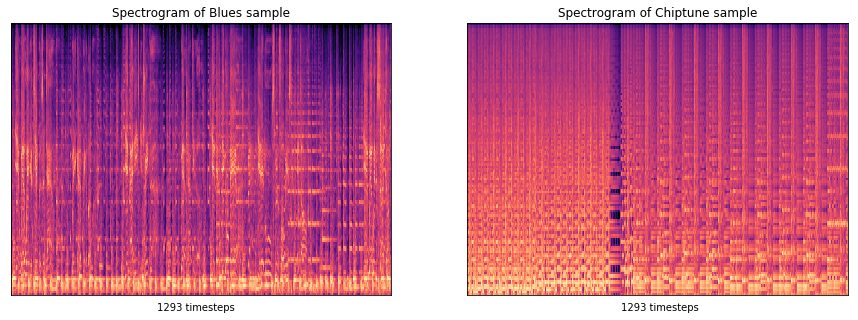

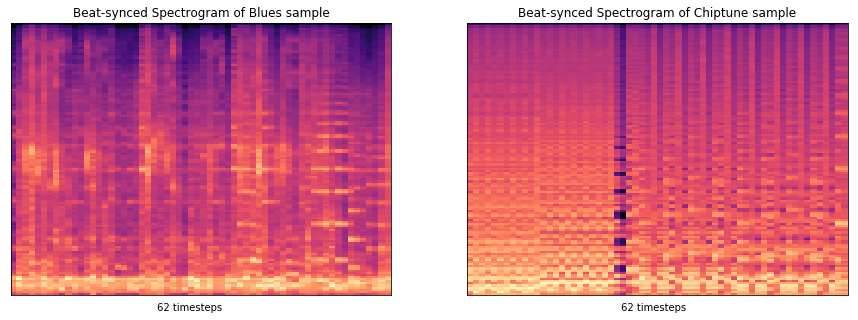

In [7]:
printSpectrum(['fma_genre_spectrograms','fma_genre_spectrograms_beat'])

* What is a spectrogram?
 * a representation of the frequenies of a signal as it varies with time
* Why beat-sync?
 * in order to reduce the size of the samples (#timestemps) without losing useful information
 * we can see that general form of the spectrum didn't change in both cases
* Spectograms Comparison
 * Blues song shows slow/smooth changes on frequency over time,
 * while Chiptune show faster changes and there is an obvious time period with total silence

### step 3

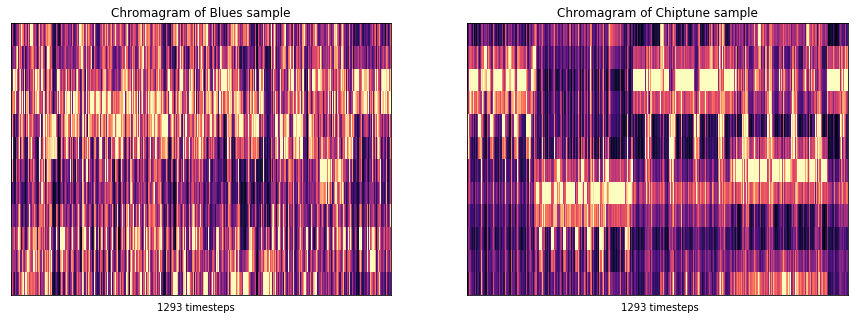

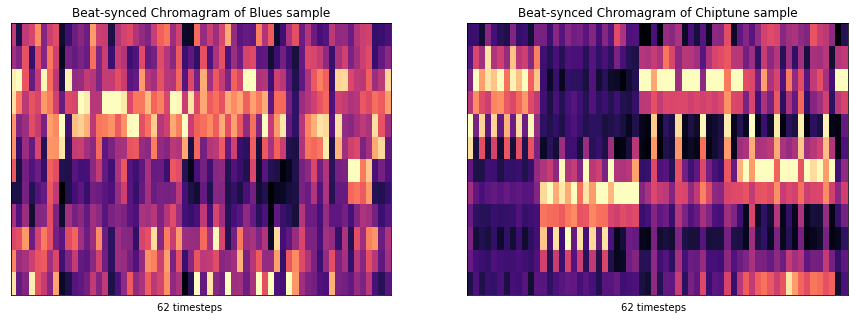

In [8]:
printSpectrum(['fma_genre_spectrograms','fma_genre_spectrograms_beat'], printChroma=True)

* What is a chromagram?
 * a representation of the pitches (commolny 12 categories are being used) of a music signal as it varies with time
* Why beat-sync?
 * in order to reduce the size of the samples (#timestemps) without losing useful information
 * we can see that general form of the chromagram didn't change in both cases

### step 4

a)

In [9]:
# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


# TODO: Comment on howv the train and validation splits are created.
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?
# Train & Validation Splits:
# 1. shuffle the data in order to have them in a total random order*
# 2. set a seed in order the above random order to be the same while we optimize our models
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, test_size=None, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if test_size:
        test_split = int(np.floor(test_size * dataset_size))
        
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    val_indices = indices[:val_split]
    if test_size:
        test_indices = indices[val_split:(val_split+test_split)]
        train_indices = indices[(val_split+test_split):]
    else:                                             
        train_indices = indices[val_split:]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)                         

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    
    if test_size:
        test_sampler = SubsetRandomSampler(test_indices)
        test_loader= DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
        
        return train_loader, val_loader, test_loader
    
    else:
        return train_loader, val_loader
    


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
# padding is needing because we use batches and at the same time the #timesteps is different across our saples
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1


class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, chroma=False, read_spec_fn=None, multitask=False, label_index=None):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping, multitask=multitask, label_index=label_index)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if multitask:
            self.labels = np.array(labels)
        elif isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping, multitask=False, label_index=None):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        ids= []
        for l in lines:
            if multitask == 1:
                parts= l[0].split(',')
                _id= parts[0]
                if label_index:
                    label= np.double(parts[1:][label_index])
                else:
                    label= [ np.double(part) for part in parts[1:]]
            else:
                
#             if multitask == 1:
#                 parts= l[0].split(',')
#                 _id= parts[0]
#                 label= float(parts[1:][label_index])
#             else:
                label = l[1]
                if class_mapping:
                    label = class_mapping[l[1]]
                # Kaggle automatically unzips the npy.gz format so this hack is needed
                _id = l[0].split('.')[0]
            if not label:
                continue
            ids.append(_id)
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels


    def __getitem__(self, item):
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]).astype('float32'), self.labels[item], l

    def __len__(self):
        return len(self.labels)

    
# ##################################################################################
# # load mel spectrograms
# ##################################################################################
# mel_specs = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_mel_spectrogram)
# train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
# test_loader_mel = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_mel_spectrogram)
# test_loader_mel, _ = torch_train_val_split(test_loader_mel, 32 ,32, val_size=0)


# ##################################################################################
# # load beat synced mel spectrograms
# ##################################################################################
# beat_mel_specs = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_mel_spectrogram)
# train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
# test_loader_beat_mel = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_mel_spectrogram)
# test_loader_beat_mel, _ = torch_train_val_split(test_loader_beat_mel, 32 ,32, val_size=0)


# ##################################################################################
# # load chromagrams
# ##################################################################################
# chroma_specs = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)
# train_loader_chroma, val_loader_chroma = torch_train_val_split(chroma_specs, 32 ,32, val_size=.33)
# test_loader_chroma = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_chromagram)
# test_loader_chroma, _ = torch_train_val_split(test_loader_chroma, 32 ,32, val_size=0)


##################################################################################
# load fused speectrogram + chromagram for the full (non-beat-synced) data
##################################################################################
specs_fused = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
#train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33,shuffle=True, seed=42)
train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)
test_loader = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)


# ##################################################################################
# # load fused speectrogram + chromagram for the full (beat-synced) data
# ##################################################################################
# specs_fused_beat = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
#      train=True,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_fused_spectrogram)
# train_loader_beat, val_loader_beat = torch_train_val_split(specs_fused_beat, 32 ,32, val_size=.33)
# test_loader_beat = SpectrogramDataset(
#      '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
#      train=False,
#      class_mapping=class_mapping,
#      max_length=-1,
#      read_spec_fn=read_fused_spectrogram)
# test_loader_beat, _ = torch_train_val_split(test_loader_beat, 32 ,32, val_size=0)

* Let's highlight some key point in the data loading process
 * spectrograms and chromagrams at both the original and the beat-synced version are pre-computed and given within a specific forder structure
 * beat-synced version of our data reduces the data size while keeps most of the information
 * we group some similar classes in order to make the classification task a bit easier
 * we remove some under-represented classes because it's kind of impossible to learn something useful for them
 * we padd our different-length sequences in order to use batches
 * we shuffle our data because their initial order could not be random
 * we use seed in order the above random order to be the same while we optimize our models
 * we use a train-validation-test split
 * we tranform our string labels into integers

#### b)

We group classes in order to make the problem a bit easier<br>
and we even remove the samples of under-represented classes because it's kind of impossible to learn something useful.

#### c)

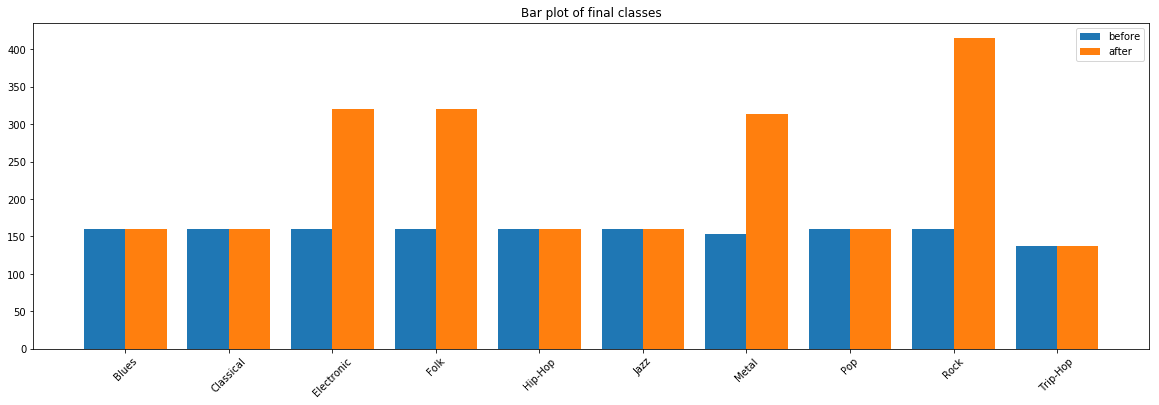

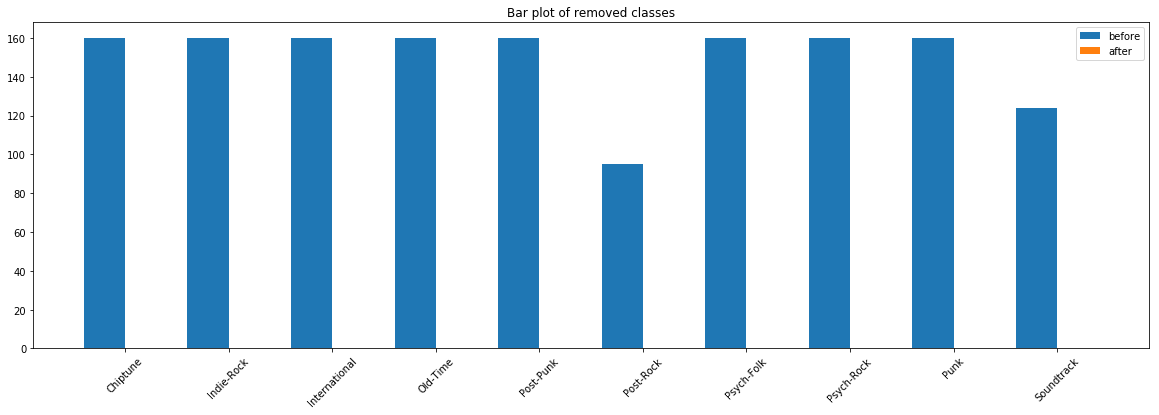

In [10]:
final_classes= ['Blues','Classical','Electronic','Folk','Hip-Hop','Jazz','Metal','Pop','Rock','Trip-Hop','Chiptune','Indie-Rock','International','Old-Time','Post-Punk','Post-Rock','Psych-Folk','Psych-Rock','Punk','Soundtrack']
counts_init= [160,160,160,160,160,160,153,160,160,137,160,160,160,160,160,95,160,160,160,124]
counts_final= [160,160,320,320,160,160,313,160,415,137,0,0,0,0,0,0,0,0,0,0]


for (l,r),sub in zip([[0,10],[10,20]],['final','removed']):
    plt.figure(figsize=(20,6))
    x= np.arange(len(final_classes[l:r]))
    width= 0.4
    plt.bar(x-width/2, counts_init[l:r], width=width, label='before')
    plt.bar(x+width/2, counts_final[l:r], width=width, label='after')
    plt.xticks(rotation=45)
    plt.title('Bar plot of '+sub+' classes')
    plt.xticks(x,final_classes[l:r])
    plt.legend()
    plt.show();

### step 5

<h3 align="center">In this step there are 4 datasets on which I train a LSTM model, as follows.</h3>

* features that are constant
 * learning rate: 0.00001
 * early stopping with patience: 50 epochs
 * regularization
 

* features that vary
 * uni-directional or bidirectional LSTM architecture
 * dropout

#### a) use only original spectrograms

In [ ]:
task= 'classification'
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'input_size': 128,
                'hidden_dim': 50,
                'output_size': 10,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.00001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'case1_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
model.train_model(train_loader_mel, val_loader_mel)
model.download_model()

In [ ]:
file= 'case1_lstm_drp10.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader_mel,val_loader_mel,test_loader_mel, filename=file, class_report=True)

| Accuracy Board 	| uni-LSTM 	| uni-LSTM + dropout 10% 	| bi-LSTM 	|
|:--------------:	|:--------:	|:----------------------:	|:-------:	|
|    train set   	|   36.2%  	|          36.2%         	|  44.1%  	|
| validation set 	|   37.4%  	|          37.1%         	|  42.4%  	|
|    test set    	|   31.0%  	|          31.0%         	|  36.3%  	|

#### b) use only beat-synced spectrograms

In [ ]:
task= 'classification'
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'input_size': 128,
                'hidden_dim': 50,
                'output_size': 10,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0.1,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.00001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'case2_lstm_drp10.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
model.train_model(train_loader_beat_mel, val_loader_beat_mel)
model.download_model()

In [ ]:
file= 'case2_lstm.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader_beat_mel,val_loader_beat_mel,test_loader_beat_mel, filename=file, class_report=True)

| Accuracy Board 	| uni-LSTM 	| uni-LSTM + dropout 10% 	| bi-LSTM 	|
|:--------------:	|:--------:	|:----------------------:	|:-------:	|
|    train set   	|   40.8%  	|          36.1%         	|  46.6%  	|
| validation set 	|   39.9%  	|          36.8%         	|  48.7%  	|
|    test set    	|   33.7%  	|          32.3%         	|  37.4%  	|

#### c) use only original chromagrams

In [ ]:
task= 'classification'
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'input_size': 12,
                'hidden_dim': 50,
                'output_size': 10,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0.1,
                'bidirectional': True,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.00001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'case3_lstm_drp10.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_chroma)
model.train_model(train_loader_chroma, val_loader_chroma)
model.download_model()

In [ ]:
file= 'case3_lstm.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader_chroma,val_loader_chroma,test_loader_chroma, filename=file, class_report=True)

| Accuracy Board 	| uni-LSTM 	| uni-LSTM + dropout 10% 	| bi-LSTM 	|
|:--------------:	|:--------:	|:----------------------:	|:-------:	|
|    train set   	|   19.5%  	|          20.3%         	|  21.3%  	|
| validation set 	|   22.2%  	|          21.3%         	|  22.1%  	|
|    test set    	|   20.0%  	|          19.5%         	|  20.3%  	|

#### d) use both original spectrograms and chromagrams

In [ ]:
task= 'classification'
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 10,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.00001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'case4_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
model.train_model(train_loader, val_loader)
model.download_model()

In [ ]:
file= 'case4_lstm_bi.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader,val_loader,test_loader, filename=file, class_report=True)

| Accuracy Board 	| uni-LSTM 	| uni-LSTM + dropout 10% 	| bi-LSTM 	|
|:--------------:	|:--------:	|:----------------------:	|:-------:	|
|    train set   	|   33.5%  	|          35.7%         	|  50.8%  	|
| validation set 	|   34.1%  	|          35.1%         	|  49.3%  	|
|    test set    	|   31.5%  	|          31.1%         	|  38.8%  	|

### Step 6

### a-[](http://)d) Detailed Model Evaluation

<h3 align="center">In this step I consider only the model with the best LSTM accuracy on the validation set</h3>

The best LSTM model is a bidirectional LSTM that were trained on both the original spectrograms and chromagrams (case d)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 100, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)



 ...... Error List ......

Error 1.4357 [train set]
Error 1.3955 [validation set]
Error 1.7965 [test set]



 ...... Accuracy List ......

Accuracy 49.5% [train set]
Accuracy 52.0% [validation set]
Accuracy 38.8% [test set]


 .................. Classification Report ..................

              precision    recall  f1-score   support

           0       0.50      0.10      0.16        52
           1       0.71      0.82      0.76        56
           2       0.46      0.75      0.57        99
           3       0.49      0.65      0.56       113
           4       0.60      0.54      0.57        46
           5       0.50      0.12      0.19        50
           6       0.60      0.60    

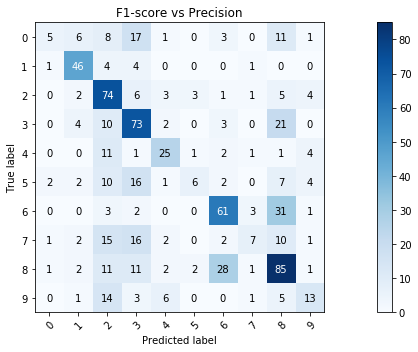

In [11]:
#this file contains the best LSTM model
file= 'case4_lstm_bi.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader,val_loader,test_loader, filename=file, class_report=True)

### e)

#### Metrics Explanation for multiclass classification
##### * assume #classes = C 

#### 1) How a confusion matrix is getting filled?

1. We initialize the confuzion matrix of dimension CxC with zeros 
2. $ \forall{} \text{sample}$
    * we predict it's class, say $ ω_j $ $\:\:\:\:\:\:\:\:\:\:\:\:\:( ω_3 $ in the example)
    * and get it's true class, say $ ω_i $ $\:\:\:\:\:\:\:\:\:\: ( ω_2 $ in the example)
    * we add 1 to the element at $ (i,j) $  $\:\:\:\:\:\: ((2,3) $ in the example)

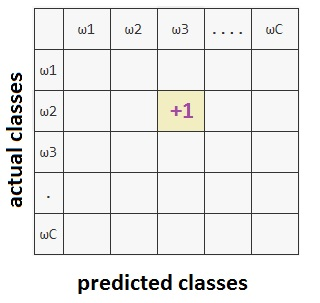

In [12]:
Image('/kaggle/input/conf-matrix/cnf_matrix.jpg')

#### 2) TP / TN / FP / FN

The following applies to every class, but here we examine $ ω_2 $.

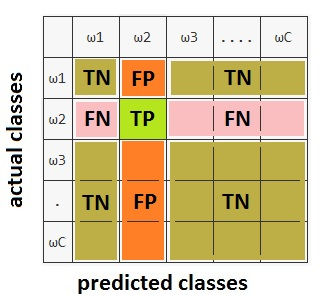

In [13]:
Image('/kaggle/input/tptnfpfn/TPTN.jpg')

#### 3) accuracy / precision / recall / f1 score

#### per class metrics
$ \:\:\:\: Precision_i = \frac{TP_i}{TP_i + FP_i} = \frac{\text{#this class true guesses}}{\text{#this class true guesses} + \text{#this class wrong guesses}}$
<br> $ \:\:\:\:\:\:\:\: \text{ when we predict a certain class, how precise are we?}$
<br><br>$ \:\:\:\: Recall_i = \frac{TP_i}{TP_i + FN_i} = \frac{\text{#this class true guesses}}{\text{#this class true guesses} + \text{#this class misses}}$
<br> $ \:\:\:\:\:\:\:\: \text{ when a certain class exists, how frequently we predicts it?}$
<br><br>$ \:\:\:\: \text{F1-}score_i = 2 * \frac{Precision_i * Recall_i}{Precision_i + Recall_i}$
<br> $ \:\:\:\:\:\:\:\:  \text{1. equals to the harmonic_mean}(Precision_i,Recall_i) \leq \text{average_mean}(Precision_i,Recall_i)$
<br> $ \:\:\:\:\:\:\:\:  \text{2. gives equal weight to precision and recall}$

<br>
#### overall metric
* Binary classification
$ \:\:\:\: Accuracy = \frac{TP + TN}{TP + FP + FN + TN}$
<br> $ \:\:\:\:\:\:\:\: \text{the proportion of correctly classified samples out of all the samples}$
* Multi-class classification
$ \:\:\:\: Accuracy = \frac{\sum_{i=1}^{C} TP_i}{ \text{#all guesses}}$
<br> $ \:\:\:\:\:\:\:\: \text{the proportion of correctly classified samples out of all the samples}$

#### 4) micro / macro averaged precision / recall / f1 score

Macro/micro averaged scores combine the above per-class scores in order to result in the classifier’s overall score (a signle number).

* micro: count the total TP, FN and FP by examining all the samples together 
* macro: arithmetic mean of the per-class scores
* weighted: weighted-average of the per-class scores. The weighting factor of each class is called "support" (the number of true instances of this class). Other factors can be used, too.


Note the following:
 * $ Precision\text{-}micro = Recall\text{-}micro = F1\text{-}micro = Accuracy $
 * macro-metrics does not take label imbalance into account.
 * weighted alters ‘macro’ to account for label imbalance,  F1-macro can result in an score that is not between precision and recall.

#### 5) Πότε μπορεί να έχω μεγάλη απόκλιση ανάμεσα στο micro/macro f1 score και τι σημαίνει αυτό; 

The difference between F1-micro (= Accuracy) and F1-macro is shown above.

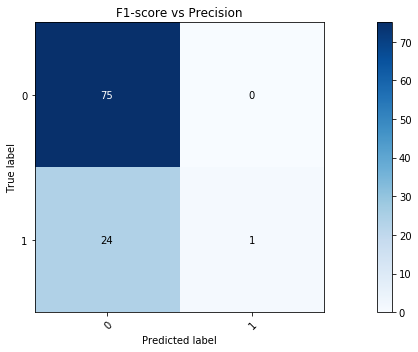

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        75
           1       1.00      0.04      0.08        25

    accuracy                           0.76       100
   macro avg       0.88      0.52      0.47       100
weighted avg       0.82      0.76      0.67       100



In [14]:
def plot_confusion_matrix( y_true, y_pred, fig, ax, allClasses, normalize=False, title=None, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = [ elem for elem in unique_labels(y_true, y_pred) if elem in allClasses]
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        #show all the ticks
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax
    
y_true = [0]*75+[1]*25
y_pred = [0]*99+[1]

fig, ax= plt.subplots(1,1,figsize=(15,5))
plot_confusion_matrix(y_true, y_pred, fig, ax, allClasses=np.arange(3), title='F1-score vs Precision')
plt.show() #keep this printing order
print(classification_report(y_true, y_pred))

F1-micro = Accuracy happens to be relativly high, 76%<br>
but F1-macro has significantly lower value, 47% due to the low f1-score of the second class which is a result of it's very low Recall. 

#### 6) Υπάρχουν προβλήματα όπου το precision με ενδιαφέρει περισσότερο από το recall και αντίστροφα; Είναι ένα καλό accuracy / f1 αρκετό σε αυτές τις περιπτώσεις για να επιλέξω ένα μοντέλο;

$ \:\:\:\: Precision >> Recall $
<br> $ \:\:\:\:\:\:\:\: \text{e.g. Email spam detection: the cost of False Positives is high (positive = spam),} $
<br> $ \:\:\:\:\:\:\:\:\:\:\:\:\:\:\: \text{meaning that the user might lose important emails}$

$ \:\:\:\: Recall >> Precision $                                
<br> $ \:\:\:\:\:\:\:\: \text{e.g. Sick Patient Detection: the cost of False Negatives is high (negative = healthy),}$
<br> $ \:\:\:\:\:\:\:\:\:\:\:\:\:\:\: \text{meaning that a sick patient, who predicted as healty, might lose their life}$

In the above cases, using Accuracy or an aggregated form of F1-score is not a meaningful choice.  

    

* notes:
 * step 4: αναλυτική παρουσίαση
 * accuracy 20%-30% 

## b) main

### step7:

#### a)

* ConvNetJS demo trains a Convolutional Neural Network on the MNIST dataset
* The CNN architecture consists of: 
 * 2 x { convolutional layer > relu function > pool layer },  following by 
 * { fully connected layer > softmax layer }
* The 1st convolutional layer consists of 8 filters, while the 2nd of 16 filters.
* By observing the respective 8 and 16 activations, we can tell that the Network learns:
 * more abstract features such as corners, edges and interest points at the first layer and
 * more complicated/task-specific features such as circles and large lines at the second layer

b)

CNN implementation is at the start of this project

c)

* **2D convolutions**: CNNs are the NNs for the images. Instead of letting each neuron to connect with every pixel, we strictly define each neuron to connect to a square-subarea of the image. Now, we use filters that slide across all the regions of the image trying to find a specific feature. Each filter correspond to several neurons that of course share the weights.<br><br>
* **Batch normalization:** Batch normalization is a technique to standardize the (direct) inputs of a network or the activations of the prior layers and aims to:
 * accelerate training and
 * provides some regularization, reducing generalization error<br><br>
* **ReLU activation**: ReLU activation
 * is a non-linear component that is definetely needed in order to be logical to use multiple layers and so, manage to learn complex things
 * doesn't saturate when input gets large
 * doesn’t have the vanishing gradient problem
 * is very quick to compute<br><br>
* **Max pooling**: Max pooling is a sample-based process which
 * aims to down-sample the input representation without losing the useful information
 * helps with the overfitting problem by providing an abstracted form of the representation

d)

In [ ]:
task= 'classification'
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'output_size': 10,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1000,
        'learning_rate': 0.00001,
        'early_stopping': {
            'patience': 20,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'case4_cnn_pat25.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader)
model.train_model(train_loader,val_loader)
model.download_model()

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bia

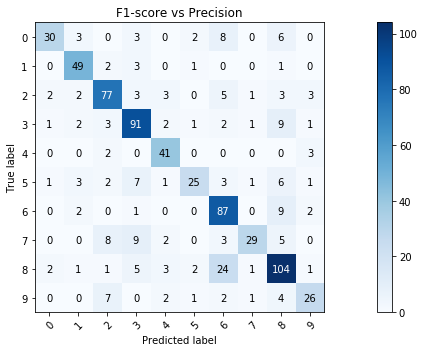

In [15]:
file= 'case4_cnn.pt'
model= ΜyPytorchModel()
model.evaluate_model(train_loader,val_loader,test_loader, filename=file, class_report=True)

e)

Models Comparison

Note that accuracy is being used as the evaluation metric because:
* the dataset is quite balanced
* all the classes are equally important

|  Models Comparison 	| Best LSTM 	| Best CNN 	|
|:------------------:	|:---------:	|:--------:	|
| validation set acc 	|   52.0%   	|   73.6%  	|
|    test set acc    	|   38.8%   	|   42.4%  	|

The best CNN is by far better than the best LSTM based on their performance on the validation set and also generalizes in a better way.

### step8

One dataloader for valence, energy and danceability<br>
An index will being used in case of regression for one of these quantities

In [16]:
mel_specs_multi = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/multitask_dataset/',
     train=True,
     max_length=-1,
     read_spec_fn= read_fused_spectrogram,
     multitask=True)
train_loader_mel_multi, val_loader_mel_multi, test_loader_mel_multi = torch_train_val_split(mel_specs_multi, 32 ,32, val_size=.25, test_size=.15, shuffle=True, seed=42)

a)

Regression implementation for CNN is placed at the start of this project

### 1. CNN

b)

valence

In [ ]:
task= 'regression'
dataloader_index= 0
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index': dataloader_index
                 },
                'output_size': 1,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index': dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_a_cnn.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [17]:
file= 'regression_a_cnn.pt'
model= ΜyPytorchModel()
outs_a_cnn, error_a_cnn= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=1, bias

c)

Energy

In [ ]:
task= 'regression'
dataloader_index= 1
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index': dataloader_index
                 },
                'output_size': 1,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index': dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_b_cnn.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [18]:
file= 'regression_b_cnn.pt'
model= ΜyPytorchModel()
outs_b_cnn, error_b_cnn= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=1, bias

d)

Danceability

In [ ]:
task= 'regression'
dataloader_index= 2
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index': dataloader_index
                 },
                'output_size': 1,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index': dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_c_cnn.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [19]:
file= 'regression_c_cnn.pt'
model= ΜyPytorchModel()
outs_c_cnn, error_c_cnn= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=1, bias

e)

Spearman correlation

original labels

In [20]:
labels_list= []
for _, labels, _ in val_loader_mel_multi:
    labels_list.append(labels)
        
#tensors to numpy
real_labels= np.array([x.cpu().data.numpy() for out in labels_list for x in out])

predicted labels

In [21]:
predicted_labels= np.concatenate((outs_a_cnn,outs_b_cnn,outs_c_cnn),axis=1)

In [22]:
corr_list= []
for pred,real in zip(predicted_labels,real_labels):
    corr_list.append(spearmanr(pred,real)[0])
    
print('Mean Spearman Correlation is',np.mean(corr_list))

Mean Spearman Correlation is 0.06428571428571428


### 2. LSTM

b)

Valence

In [ ]:
task= 'regression'
dataloader_index= 0
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index':dataloader_index
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 1,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index':dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_a_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [23]:
file= 'regression_a_lstm.pt'
model= ΜyPytorchModel()
outs_a_lstm, error_a_lstm= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 50, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


c)

Energy

In [ ]:
task= 'regression'
dataloader_index= 1
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index':dataloader_index
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 1,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index':dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_b_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [24]:
file= 'regression_b_lstm.pt'
model= ΜyPytorchModel()
outs_b_lstm, error_b_lstm= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 50, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


d)

Danceability

In [ ]:
task= 'regression'
dataloader_index= 2
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index':dataloader_index
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 1,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index':dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_c_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [25]:
file= 'regression_c_lstm.pt'
model= ΜyPytorchModel()
outs_c_lstm, error_c_lstm= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 50, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


e)

Spearman correlation

original labels

In [26]:
labels_list= []
for _, labels, _ in val_loader_mel_multi:
    labels_list.append(labels)
        
#tensors to numpy
real_labels= np.array([x.cpu().data.numpy() for out in labels_list for x in out])

predicted labels

In [27]:
predicted_labels_lstm= np.concatenate((outs_a_lstm,outs_b_lstm,outs_c_lstm),axis=1)

In [28]:
corr_list= []
for pred,real in zip(predicted_labels_lstm,real_labels):
    corr_list.append(spearmanr(pred,real)[0])
    
print('Mean Spearman Correlation is',np.mean(corr_list))

Mean Spearman Correlation is 0.09107142857142857


## extra

### step9a

a)

Transfer Learning

a.1)

To paper "How transferable are features in deep neural nertworks?" ερευνά το βαθμό στον οποίο έχει νόημα να χρησιμοποιούμε βάρη από νευρωνικά δίκτυα τα οποία είναι εκπαιδευμένα σε κάποιο task για την επίλυση ενός άλλου task και τις δυσκολίες που υπάρχουν. Το εν λόγω paper καταλήγει στα εξής συμπεράσματα:

* Ανάλογα με το βάθος στο οποίο βρίσκονται τα layers που θέλουμε να μεταφέρουμε χωρίζονται σε γενικά (που εξάγουν γενικά χαρακτηριστικά από τα δεδομένα) και σε ειδικά (που εξάγουν πληροφορίες οι οποίες είναι περισσότερο task-specific). Η μεταφορά των πρώτων είναι θεμιτή και γενικά προσφέρει πληροφορία καθώς λειτουργούν σα feature extractors ενώ τα δεύτερα δύσκολα θα προσφέρουν κάτι στο δίκτυο.
* Πολλές φορές παρατηρούμε πτώση στην απόδοση κατά το transfer learning η οποία οφείλεται στο φαινόμενο fragile co-adapted features, δηλαδή layers των οποίων οι τιμές διαμορφώθηκαν κατά την εκπαίδευση με βάση την αλληλεπίδραση με άλλα layers του δικτύου. Έτσι, όταν αφαιρέσουμε κάποια από αυτά τα layers και τα μεταφέρουμε σε άλλο δίκτυο δεν έχουμε το ίδιο καλό αποτέλεσμα, λόγω της απουσίας αυτής της αλληλεπίδρασης. Αυτά η σχέση ισχύει μάλλον κυρίως για τα μεσαία layers.
* Η μεταφορά βαρών από ένα άλλο δικτύο και η μετεκπαίδευσή τους (fine tuning) φαίνεται να βοηθάει στη γενίκευση ανεξαρτήτως του μεγέθους του dataset διότι αυτά τα βάρη συνεχίζουν και μετά από πολλές επαναλήψεις να διατηρούν κομμάτι της πληροφορίας που είχαν εξ αρχής.
* Τέλος, η επίδραση του trasfer learning μειώνεται όσο πιο ανόμοια είναι τα tasks.

a.2-4)

Best LSTM

In [ ]:
task= 'regression'
dataloader_index= 0
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index': dataloader_index
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 1,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': True,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
            'transfer_learning': {
                'tl_filename': 'case4_lstm_bi.pt'
            }
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index': dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_a_lstm_transfer_learning.pt'
    }
}
model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [29]:
file= 'regression_a_lstm_transfer_learning.pt'
model= ΜyPytorchModel()
outs_a_tl_lstm, error_a_tl_lstm= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 100, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
)


Best CNN

In [ ]:
task= 'regression'
dataloader_index= 0
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task,
                    'dataloader_index': dataloader_index
                 },
                'output_size': 1,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'transfer_learning': {
                'tl_filename': 'case4_cnn.pt'
            },
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task,
            'dataloader_index': dataloader_index
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'regression_a_cnn_transfer_learning.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [30]:
file= 'regression_a_cnn_transfer_learning.pt'
model= ΜyPytorchModel()
outs_a_tl_cnn, error_a_tl_cnn= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=50, bia

a5)

Validation MSE loss for Valence Regression

| Models Comparison 	| Best LSTM 	| Best CNN 	|
|:-----------------:	|:---------:	|:--------:	|
| single regression 	|   0.070   	|   0.051  	|
| transfer learning 	|   0.065   	|   0.058  	|


Using Tranfer Learning, we get aproximately the same performance ot the validation set.

### step 9b)

Multitask Learning

The error is being used as a\*L1 + b\*L2 + c\*L3 where a,b,c are set to 1

a)

Τo paper "One Model To Learn Them All" ερευνά το βαθμό στον οποίο ένα νευρωνικό μπορεί να μάθει διαφορετικά tasks ταυτόχρονα. Συγκεκριμένα, ασχολείται όχι μόνο με διαφορετικά tasks από το ίδιο domain αλλά και με tasks από διαφορετικά domains, όπως Image Captioning, Parsing, Machine Translation κλπ. Το καταφέρνει αυτό συνδυάζοντας δομικές μονάδες που είναι ευρέως χρησιμοποιούμενες στα επιμέρους tasks (convolutional layers, attention mechanisms κλπ.) τα οποία είναι απαραίτητα για το task στο οποίο απευθύνονται, ενώ δε ρίχνουν την απόδοση στα υπόλοιπα tasks. Επίσης, χρησιμοποιεί διαφορετικά δίκτυα για το κάθε modality για να φέρει κάθε είσοδο σε έναν κοινό τρόπο αναπαράστασης.. Το τελικό μοντέλο έχει καλή απόδοση σε όλα τα tasks ενώ παρατηρείται βελτιώση στην απόδοση για τα tasks τα οποία έχουν τα λιγότερα δεδομένα.**

b)

CNN

In [ ]:
task= 'regression-multitask'
settings={
    'cnn':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'output_size': 3,
                'kernel_size': 3,
            },
            'optional':{
                'dropout': 0
            }
        },
        'general':{
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.0001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'multi_regression_cnn.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [39]:
file= 'multi_regression_cnn.pt'
model= ΜyPytorchModel()
outs_mlt_reg_cnn, error_mlt_reg_cnn= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyCNN(
  (dropout): Dropout(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=3, bias

In [47]:
corr_list= []
for pred,real in zip(outs_mlt_reg_cnn,real_labels):
    corr_list.append(spearmanr(pred,real)[0])
    
print('Mean Spearman Correlation is',np.mean(corr_list))

Mean Spearman Correlation is 0.09642857142857143


LSTM

In [ ]:
task= 'regression-multitask'
settings={
    'lstm':{
        'model':{
            'required':{
                'task_params': {
                    'task': task
                 },
                'input_size': 140,
                'hidden_dim': 50,
                'output_size': 3,
                'n_layers': 1,
            },
            'optional':{
                'dropout': 0,
                'bidirectional': False,
                'batch_first': True,
            }
        },
        'general':{
            'pack': False,
            'printing': False,
        }
    },
    'training':{
        'task_params': {
            'task': task
         },
        'epochs': 1500,
        'learning_rate': 0.001,
        'early_stopping': {
            'patience': 50,
            'min_delta': 1e-5,
            'es_break': True
        },
        'checkpoints_file': 'multi_regression_lstm.pt'
    }
}

model= ΜyPytorchModel()
model.pick_model(**settings)
#model.one_batch_overtrain(train_loader_mel_multi)
model.train_model(train_loader_mel_multi, val_loader_mel_multi)
model.download_model()

In [40]:
file= 'multi_regression_lstm.pt'
model= ΜyPytorchModel()
outs_mlt_reg_lstm, error_mlt_reg_lstm= model.evaluate_model(train_loader_mel_multi,val_loader_mel_multi,test_loader_mel_multi, filename=file, class_report=True)

GPU is available

....... Τhis is the best model .......

MyLSTM(
  (lstm): LSTM(140, 50, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [48]:
corr_list= []
for pred,real in zip(outs_mlt_reg_lstm,real_labels):
    corr_list.append(spearmanr(pred,real)[0])
    
print('Mean Spearman Correlation is',np.mean(corr_list))

Mean Spearman Correlation is 0.09285714285714286


c)

Spearman correlation for Multitask Learning vs mulpiple regular Regression Models

| Regression Models Comparison 	|  LSTM 	|  CNN  	|
|:----------------------------:	|:-----:	|:-----:	|
|        multiple models       	| 0.091 	| 0.064 	|
|      multitask learning      	| 0.092 	| 0.096 	|


Multitask Learning improves models performance. However, in each case the spearman correlation ranges in small values